In [3]:
pip install pandas numpy scikit-learn matplotlib seaborn joblib spacy wordcloud

In [4]:
pip install pandas numpy matplotlib seaborn wordcloud textblob nltk scikit-learn

In [5]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
!python -m nltk.downloader vader_lexicon

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
pip install numpy pandas matplotlib seaborn scikit-learn nltk wordcloud scikit-plot shap

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import spacy
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Load SpaCy model for advanced preprocessing
nlp = spacy.load("en_core_web_sm")

In [4]:
# Load datasets
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [5]:
# Remove null and duplicate values from training data
train.dropna(subset=['crimeaditionalinfo'], inplace=True)
train.drop_duplicates(inplace=True)

In [6]:
# Remove null and duplicate values from test data
test.dropna(subset=['crimeaditionalinfo'], inplace=True)
test.drop_duplicates(inplace=True)

In [7]:
# Data Cleaning: Keep rows in test.csv where the category exists in train.csv
valid_categories = train['category'].unique()
test = test[test['category'].isin(valid_categories)]

In [8]:
# Display dataset structure
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 85876 entries, 0 to 93685
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            85876 non-null  object
 1   sub_category        82018 non-null  object
 2   crimeaditionalinfo  85876 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB
None


In [9]:
print(train.head())

                                category                       sub_category  \
0  Online and Social Media Related Crime  Cyber Bullying  Stalking  Sexting   
1                 Online Financial Fraud                  Fraud CallVishing   
2               Online Gambling  Betting           Online Gambling  Betting   
3  Online and Social Media Related Crime                   Online Job Fraud   
4                 Online Financial Fraud                  Fraud CallVishing   

                                  crimeaditionalinfo  
0  I had continue received random calls and abusi...  
1  The above fraudster is continuously messaging ...  
2  He is acting like a police and demanding for m...  
3  In apna Job I have applied for job interview f...  
4  I received a call from lady stating that she w...  


In [10]:
# Display dataset structure
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29067 entries, 0 to 31228
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            29067 non-null  object
 1   sub_category        27684 non-null  object
 2   crimeaditionalinfo  29067 non-null  object
dtypes: object(3)
memory usage: 908.3+ KB
None


In [11]:
print(test.head())

                                    category  \
0  RapeGang Rape RGRSexually Abusive Content   
1                     Online Financial Fraud   
2             Cyber Attack/ Dependent Crimes   
3                     Online Financial Fraud   
4                      Any Other Cyber Crime   

                           sub_category  \
0                                   NaN   
1  DebitCredit Card FraudSim Swap Fraud   
2                         SQL Injection   
3                     Fraud CallVishing   
4                                 Other   

                                  crimeaditionalinfo  
0  Sir namaskar  mein Ranjit Kumar PatraPaise neh...  
1          KOTAK MAHINDRA BANK FRAUD\r\nFRAUD AMOUNT  
2  The issue actually started when I got this ema...  
3  I am amit kumar from karwi chitrakoot I am tot...  
4  I have ordered  saree and  blouse from rinki s...  


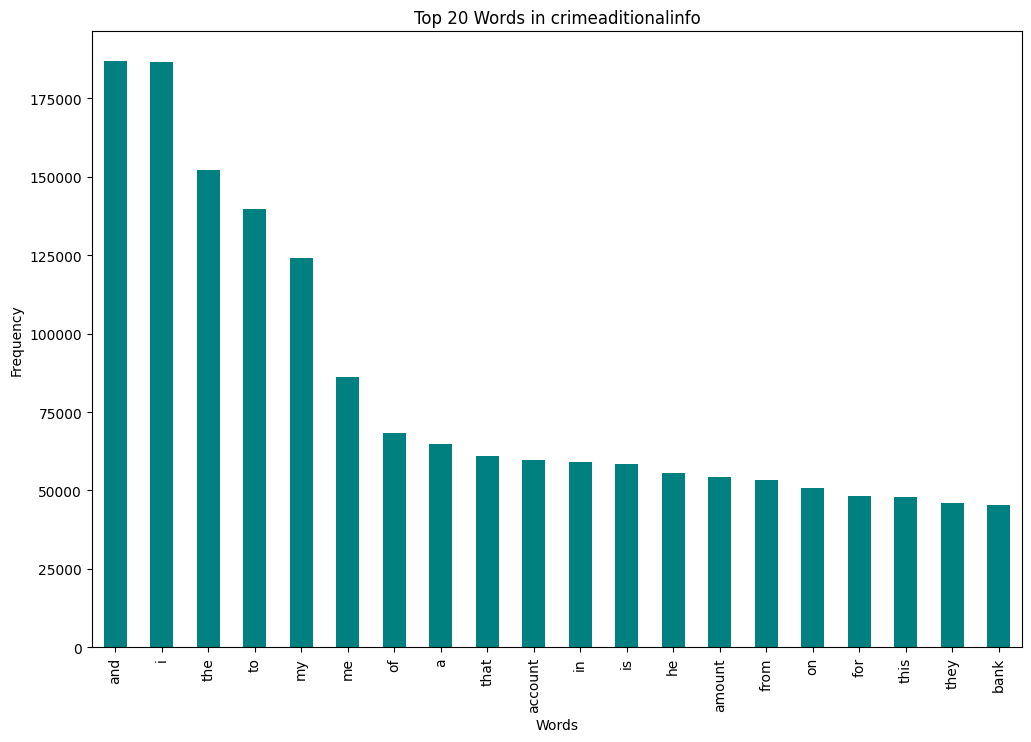

In [12]:
# EDA Visualization
def visualize_word_distribution(data, column):
    text_data = " ".join(data[column].dropna().values)
    words = re.findall(r'\w+', text_data.lower())
    word_counts = pd.Series(words).value_counts()
    plt.figure(figsize=(12, 8))
    word_counts.head(20).plot(kind='bar', color='teal')
    plt.title(f'Top 20 Words in {column}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

visualize_word_distribution(train, 'crimeaditionalinfo')

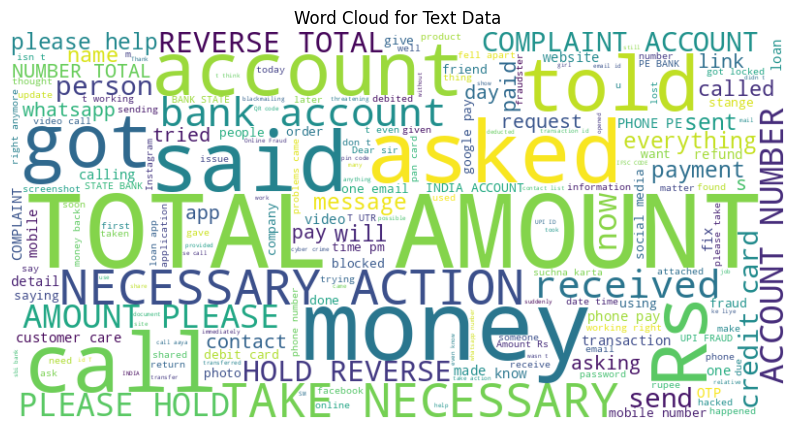

In [13]:
# Exploratory Data Analysis (EDA)
def visualize_wordcloud(data, column, title):
    """Generate word cloud for text data."""
    text = " ".join(train[column].dropna().values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word Cloud for Entire Dataset
visualize_wordcloud(train, 'crimeaditionalinfo', 'Word Cloud for Text Data')

In [14]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

In [15]:
def analyze_sentiment(text):
    """Analyze sentiment using VADER and TextBlob."""
    # Using VADER for compound score
    vader_score = sia.polarity_scores(text)['compound']
    # TextBlob polarity
    textblob_score = TextBlob(text).sentiment.polarity
    # Combine scores to derive label
    avg_score = (vader_score + textblob_score) / 2
    if avg_score > 0.05:
        return 'Positive'
    elif avg_score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [16]:
# Apply sentiment analysis
train['Sentiment'] = train['crimeaditionalinfo'].apply(analyze_sentiment)

<ipython-input-17-d5c77e5c023e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='Sentiment', palette='coolwarm')


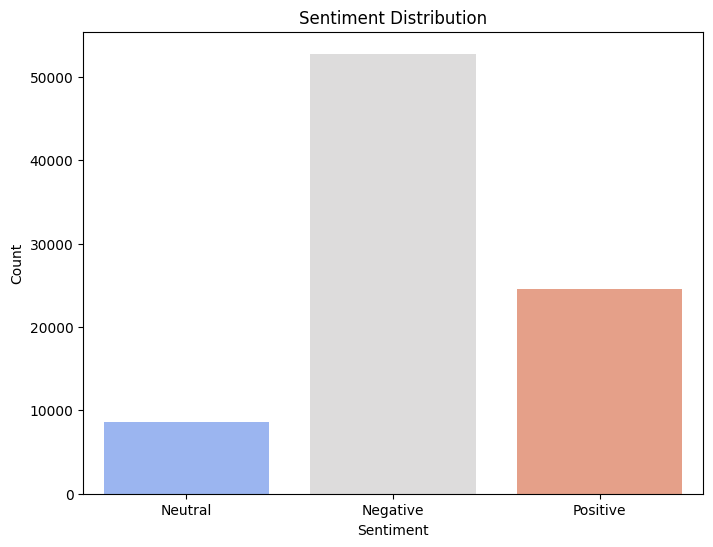

In [17]:
# Sentiment Distribution Visualization
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='Sentiment', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

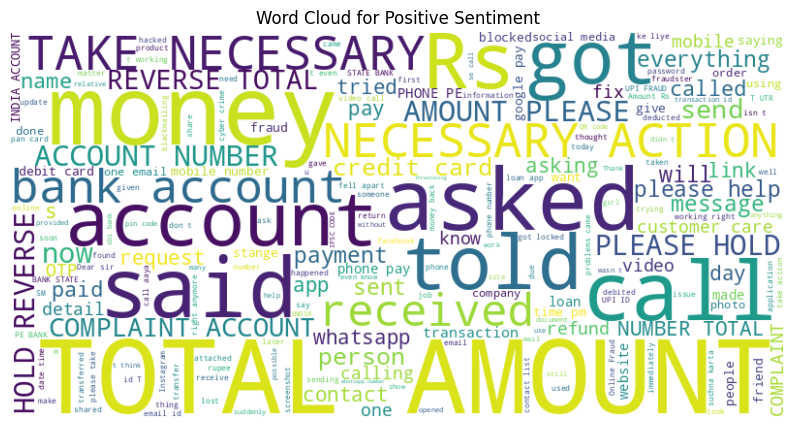

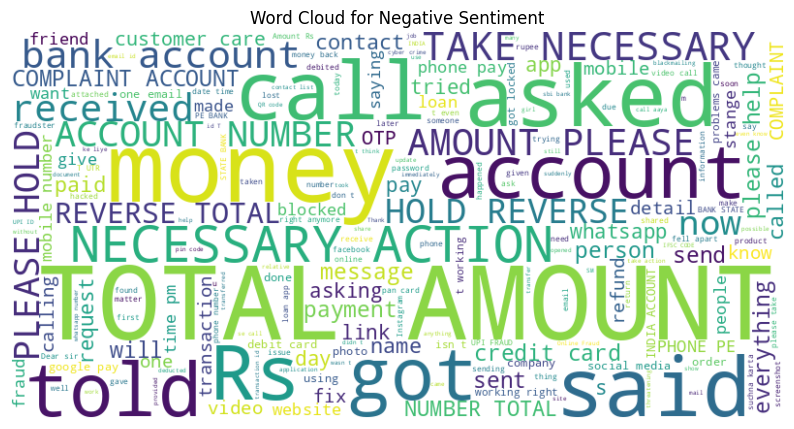

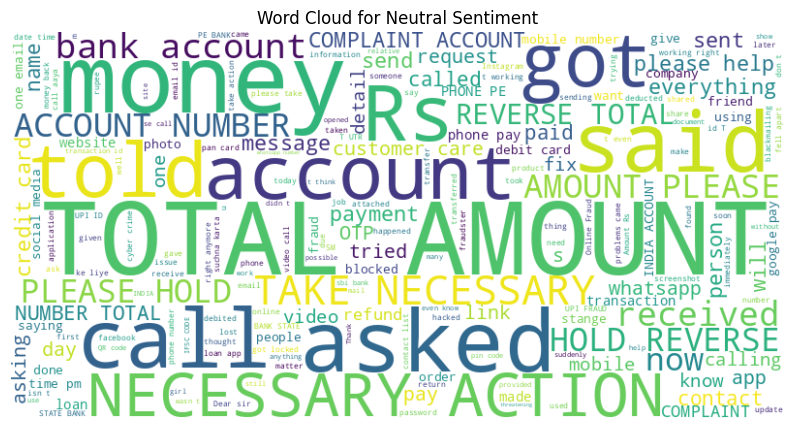

In [18]:
# Word Clouds for Each Sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    visualize_wordcloud(train[train['Sentiment'] == sentiment], 'crimeaditionalinfo', f'Word Cloud for {sentiment} Sentiment')

In [19]:
# Advanced Text Preprocessing Function
def preprocess_text_advanced(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

In [20]:
# Apply text preprocessing
train['cleaned_info'] = train['crimeaditionalinfo'].apply(preprocess_text_advanced)
test['cleaned_info'] = test['crimeaditionalinfo'].apply(preprocess_text_advanced)

In [21]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train = tfidf.fit_transform(train['cleaned_info']).toarray()
X_test = tfidf.transform(test['cleaned_info']).toarray()

In [22]:
y_train = train['category']
y_test = test['category']

In [23]:
# Random Forest Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
# Predictions
y_pred = model.predict(X_test)

In [25]:
# Add predictions to the test DataFrame
test['predicted_category'] = y_pred

# Save the DataFrame as a CSV file
output_file = "predictions.csv"
test.to_csv(output_file, index=False)

print(f"Predictions have been saved to {output_file}")

Predictions have been saved to predictions.csv


In [26]:
# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7407
Precision: 0.7136
Recall: 0.7407
F1-score: 0.6856


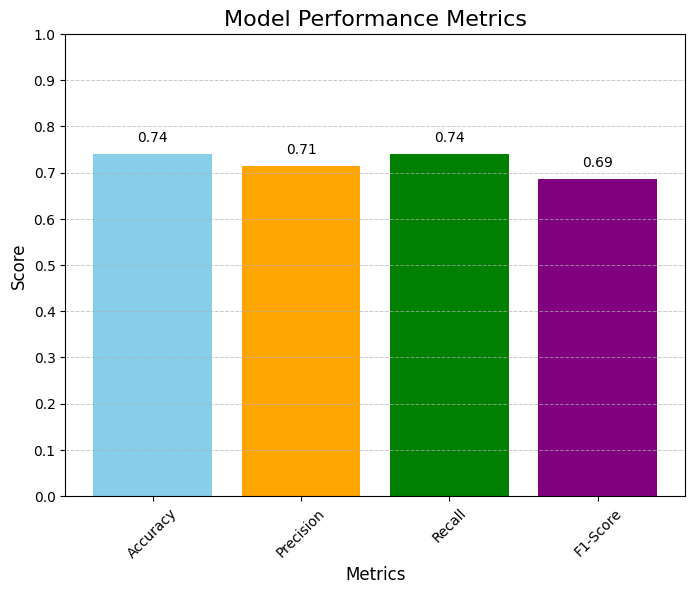

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Example values for metrics (replace these with your actual computed values)
metrics = {
    "Accuracy": 0.7407,        # Replace with your accuracy score
    "Precision": 0.7136,       # Replace with your precision score
    "Recall": 0.7407,          # Replace with your recall score
    "F1-Score": 0.6856         # Replace with your F1-score
}

# Visualization
def plot_metrics_with_labels(metrics):
    plt.figure(figsize=(8, 6))
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())

    # Bar plot
    bars = plt.bar(metric_names, metric_values, color=['skyblue', 'orange', 'green', 'purple'])
    plt.ylim(0, 1.0)  # Ensure scores are within 0 to 1
    plt.title('Model Performance Metrics', fontsize=16)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adding labels on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.2f}',
                 ha='center', va='bottom', fontsize=10, color='black')

    plt.show()

# Call the function to plot
plot_metrics_with_labels(metrics)


In [28]:
# Classification Report as DataFrame
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


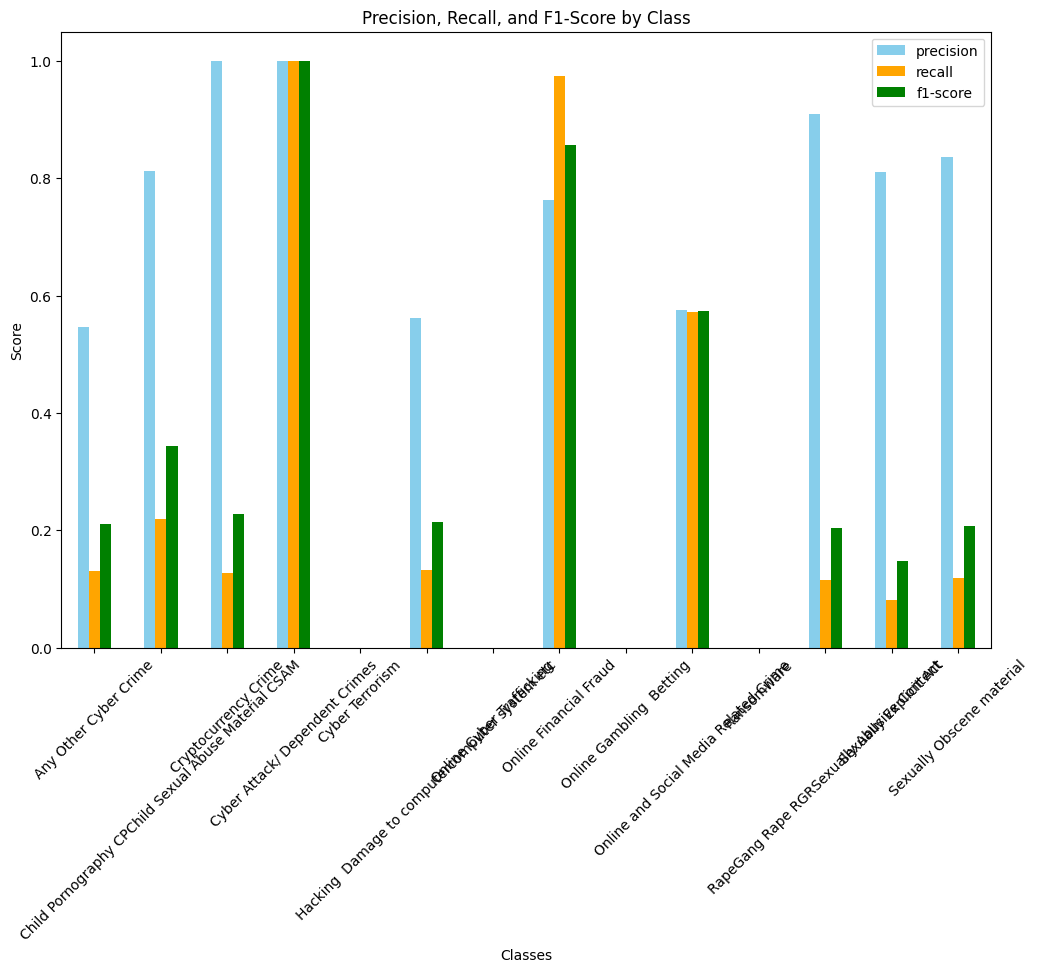

In [29]:
# Plot Precision, Recall, and F1-Score
metrics = ['precision', 'recall', 'f1-score']
report_df[metrics][:-3].plot(kind='bar', figsize=(12, 8), color=['skyblue', 'orange', 'green'])
plt.title('Precision, Recall, and F1-Score by Class')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()


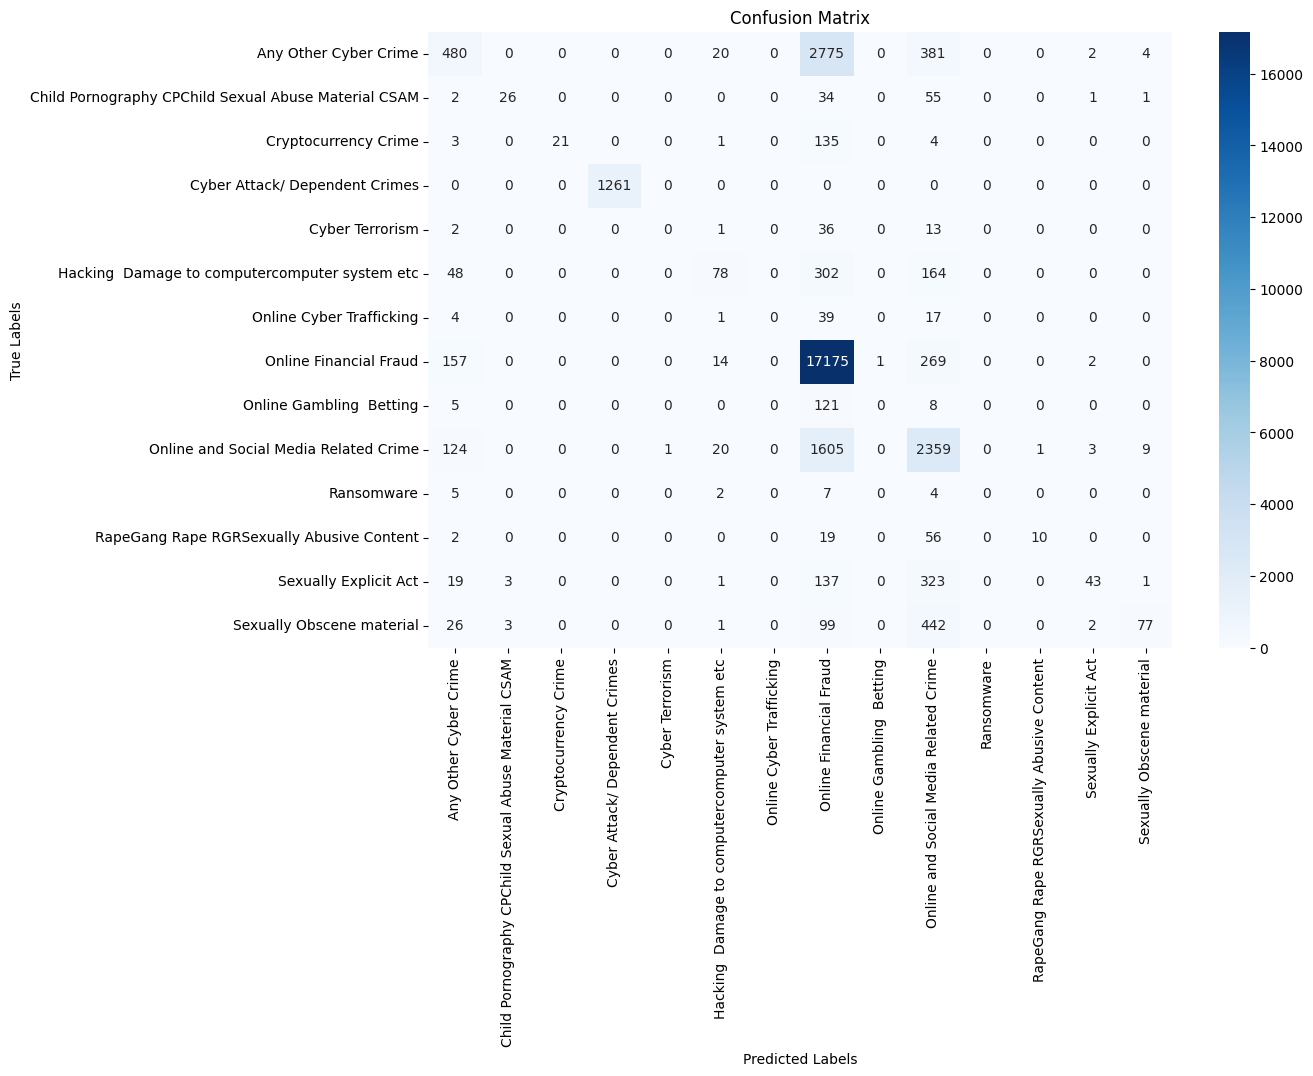

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=report_df.index[:-3], yticklabels=report_df.index[:-3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [31]:
# Feature Importance Visualization
importances = model.feature_importances_
feature_names = tfidf.get_feature_names_out()
sorted_indices = np.argsort(importances)[::-1]

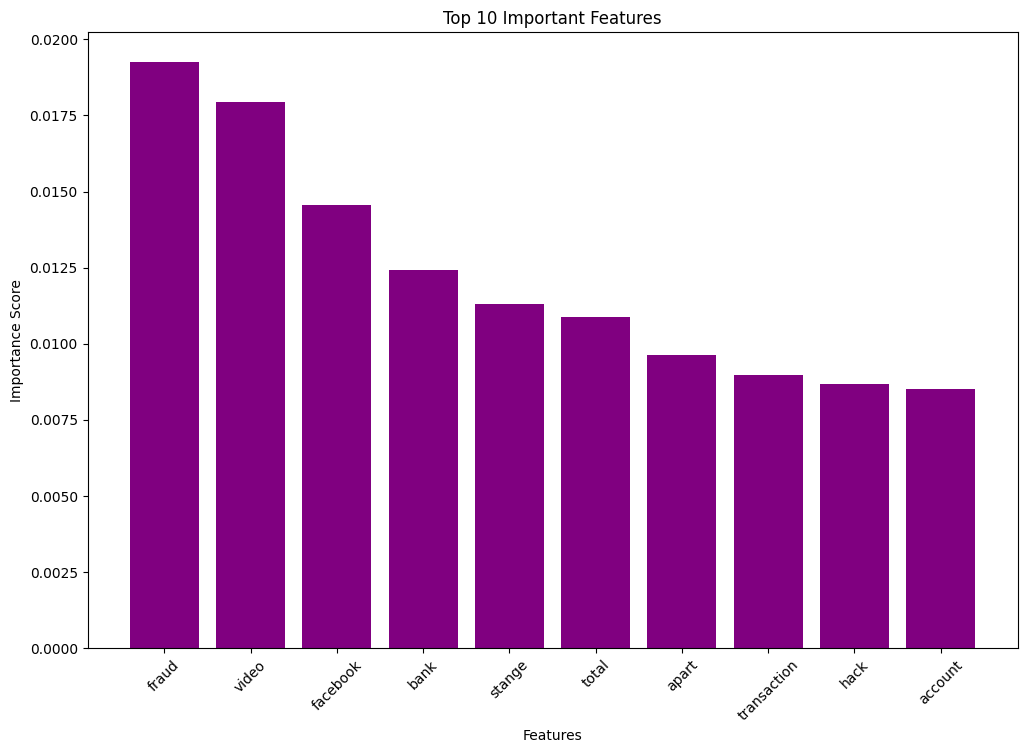

In [32]:
plt.figure(figsize=(12, 8))
plt.bar(range(10), importances[sorted_indices[:10]], align='center', color='purple')
plt.xticks(range(10), feature_names[sorted_indices[:10]], rotation=45)
plt.title("Top 10 Important Features")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

In [33]:
# ROC-AUC Visualization for Binary Categories (Optional)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [34]:
# Binarize labels
y_test_encoded = label_binarize(y_test, classes=valid_categories)
y_pred_proba = model.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


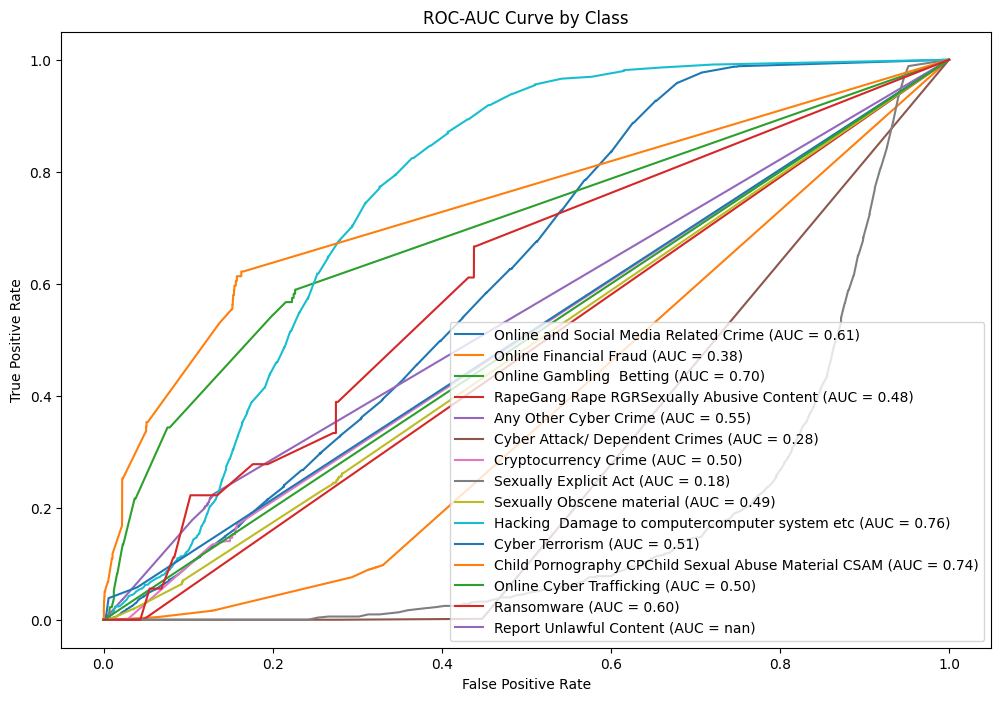

In [35]:
# Plot ROC Curve for each class
plt.figure(figsize=(12, 8))
for i, category in enumerate(valid_categories):
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')


plt.title("ROC-AUC Curve by Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


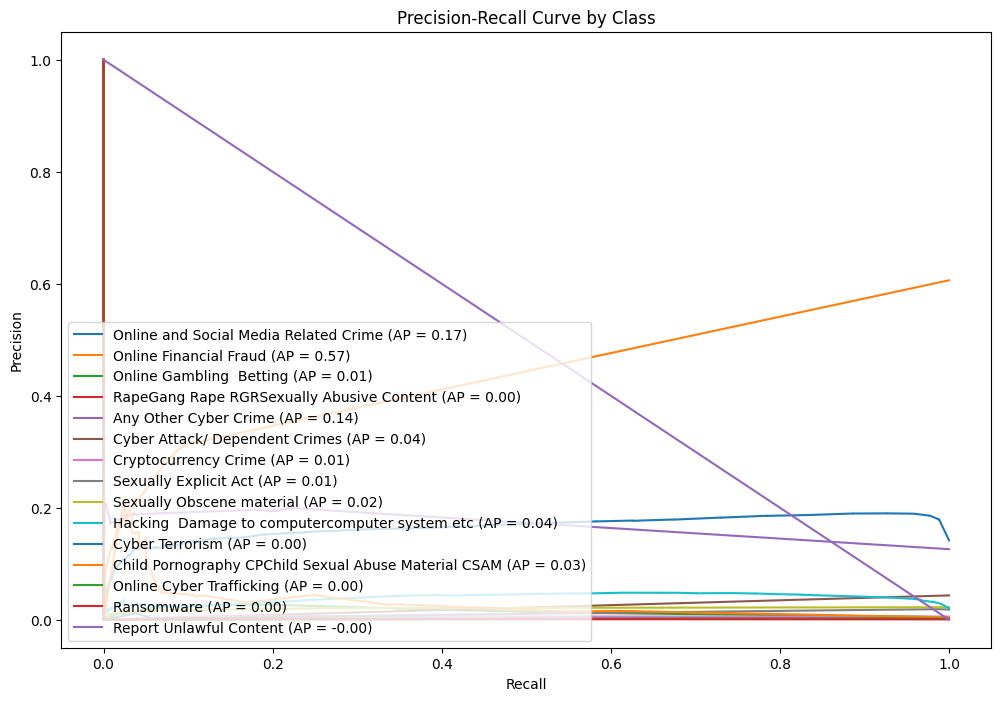

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 8))
for i, category in enumerate(valid_categories):
    precision, recall, _ = precision_recall_curve(y_test_encoded[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_test_encoded[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'{category} (AP = {avg_precision:.2f})')

plt.title("Precision-Recall Curve by Class")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

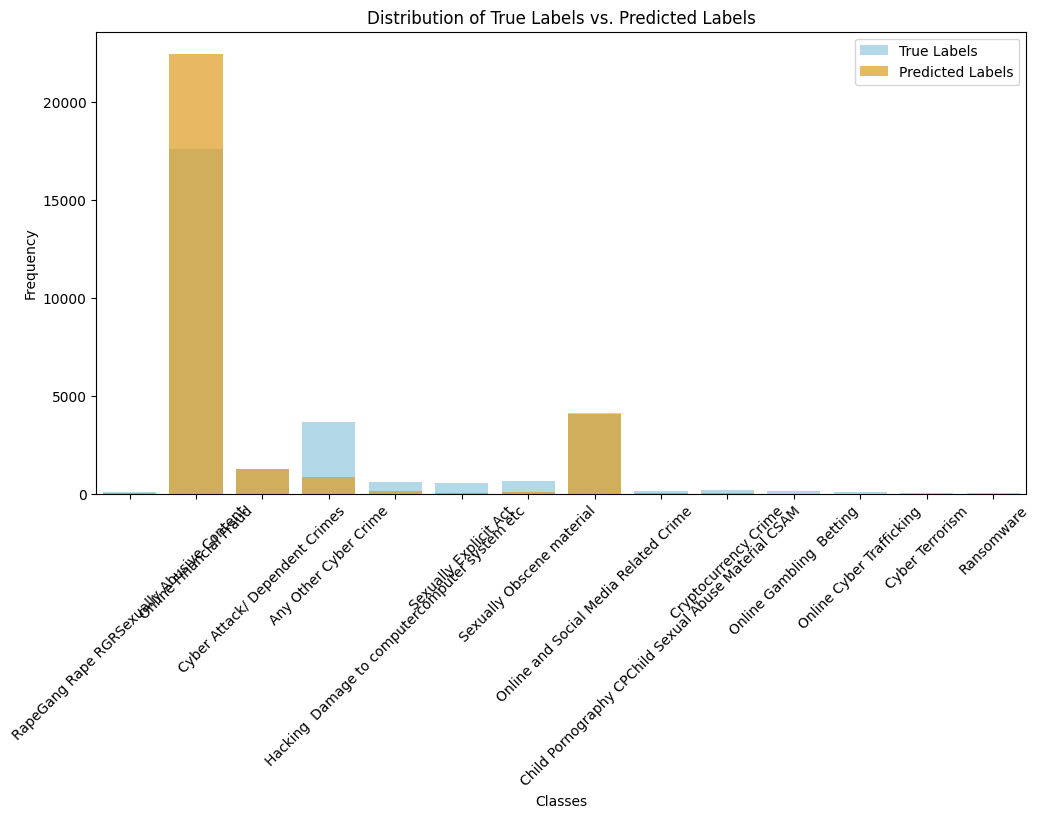

In [37]:
plt.figure(figsize=(12, 6))

# True labels
sns.countplot(x=y_test, alpha=0.7, label='True Labels', color='skyblue')

# Predicted labels
sns.countplot(x=y_pred, alpha=0.7, label='Predicted Labels', color='orange')

plt.title("Distribution of True Labels vs. Predicted Labels")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
from fpdf import FPDF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Function to preprocess user input
def preprocess_user_input(text):
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip().lower()  # Normalize spaces and lowercase
    return text

# Explainable AI setup
explainer = shap.Explainer(model, tfidf.transform)

# Function to predict and explain
def predict_and_explain(text):
    # Preprocess the text
    cleaned_text = preprocess_user_input(text)

    # Transform the text using the TF-IDF vectorizer
    text_vector = tfidf.transform([cleaned_text])

    # Get prediction
    prediction = model.predict(text_vector)[0]

    # Generate SHAP explanation
    shap_values = explainer(text_vector)

    # Save explanation plot
    explanation_file = "shap_explanation.png"
    shap.plots.waterfall(shap_values[0], show=False)
    plt.savefig(explanation_file)
    plt.close()

    return prediction, explanation_file

# Function to generate PDF report
def generate_pdf_report(user_input, prediction, explanation_file):
    pdf = FPDF()
    pdf.add_page()

    # Add title
    pdf.set_font("Arial", size=16)
    pdf.cell(200, 10, txt="Model Prediction Report", ln=True, align='C')

    # Add user input
    pdf.set_font("Arial", size=12)
    pdf.ln(10)
    pdf.cell(200, 10, txt=f"User Input: {user_input}", ln=True)

    # Add prediction
    pdf.ln(10)
    pdf.cell(200, 10, txt=f"Prediction: {prediction}", ln=True)

    # Add explanation image
    pdf.ln(10)
    pdf.cell(200, 10, txt="SHAP Explanation:", ln=True)
    pdf.ln(5)
    pdf.image(explanation_file, x=10, y=pdf.get_y(), w=190)  # Adjust dimensions as needed

    # Save the PDF
    output_pdf = "model_prediction_report.pdf"
    pdf.output(output_pdf)
    print(f"Report saved as {output_pdf}")

    return output_pdf

# User input example
user_input = input("Enter a description: ")

# Predict and explain
predicted_category, explanation_image = predict_and_explain(user_input)

# Generate and download the PDF report
pdf_file = generate_pdf_report(user_input, predicted_category, explanation_image)

try:
    from google.colab import files
    files.download(pdf_file)
except ImportError:
    print("Download the PDF from your working directory.")

In [28]:
# Save model
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']